In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, accuracy_score,
    f1_score, confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
class DataHandler:
    def __init__(self, file_path, test_size=0.3, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=0.95)
        self.categorical_cols = ['proto', 'service', 'conn_state', 'http_method', 'http_version']

    def load_and_preprocess_network(self):
        """Load and preprocess the data"""
        data = pd.read_csv(self.file_path)
        data = pd.get_dummies(data, columns=self.categorical_cols)

        # Printing dataset information
        print(f"Total records: {len(data)}")
        normal_data = len(data[data['Label'] == 0])
        attack_data = len(data[data['Label'] == 1])
        print(f"Normal data: {normal_data}")
        print(f"Attack data: {attack_data}")

        return data.drop(columns=['Label']), data['Label']

    def load_and_preprocess_weather(self):
        """Load original features without interactions"""
        data = pd.read_csv(self.file_path)

        # Printing dataset information
        print(f"Total records: {len(data)}")
        normal_data = len(data[data['Label'] == 0])
        attack_data = len(data[data['Label'] == 1])
        print(f"Normal data: {normal_data}")
        print(f"Attack data: {attack_data}")

        X = data[['temperature', 'pressure', 'humidity']]  # Original features only
        y = data['Label']
        return X, y

    def split_data(self, X, y):
        """Split data into normal and attack sets"""
        X_normal = X[y == 0]
        X_attack = X[y == 1]
        return X_normal, X_attack

    def prepare_datasets_network(self):
        """Prepare train and test datasets"""
        X, y = self.load_and_preprocess_network()
        X_normal, X_attack = self.split_data(X, y)

        # Train-test split
        X_train, X_val_normal = train_test_split(
            X_normal, test_size=self.test_size, random_state=self.random_state
        )

        # Create test set (normal + attacks)
        X_test = pd.concat([X_val_normal, X_attack])
        y_test = pd.concat([
            pd.Series(0, index=X_val_normal.index),
            pd.Series(1, index=X_attack.index)
        ])

        # Scale and apply PCA
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)

        return X_train_pca, X_test_pca, y_test

    def prepare_datasets_weather(self):
        """Proper 80/20 split with validation attacks"""
        X, y = self.load_and_preprocess_weather()
        X_normal, X_attack = self.split_data(X, y)

        # Split normal data: 80% train, 20% validation
        X_train, X_val_normal = train_test_split(
            X_normal,
            test_size=self.test_size,  # 20% for validation
            random_state=self.random_state
        )

        # Create test set
        X_test = pd.concat([X_val_normal, X_attack])
        y_test = pd.concat([
            pd.Series(0, index=X_val_normal.index),
            pd.Series(1, index=X_attack.index)
        ])

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        # X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # return X_train_scaled, X_val_scaled, X_test_scaled, y_val, y_test
        return X_train_scaled, X_test_scaled, y_test

In [3]:
class Teacher:
    def __init__(self, input_dim, learning_rate=0.001, latent_dim=32):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()
        self.threshold = None

    def _build_autoencoder(self):
        """Build the autoencoder architecture"""
        input_layer = Input(shape=(self.input_dim,))

        # Encoder
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(self.latent_dim, activation='relu')(encoded)

        # Decoder
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(self.input_dim, activation='linear')(decoded)

        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mae')
        return autoencoder

    # def _build_weather_autoencoder(self):
    #     """Simplified architecture with regularization"""

    #     input_layer = Input(shape=(self.input_dim,))

    #     # Encoder
    #     encoded = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    #     encoded = Dropout(0.3)(encoded)
    #     encoded = Dense(64, activation='relu')(input_layer)
    #     encoded = Dense(self.latent_dim, activation='relu')(encoded)

    #     # Decoder
    #     decoded = Dense(64, activation='relu')(encoded)
    #     decoded = Dense(self.input_dim, activation='linear')(decoded)

    #     autoencoder = Model(inputs=input_layer, outputs=decoded)
    #     autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mae')
    #     return autoencoder

    def train(self, X_train, epochs=100, batch_size=512, validation_split=0.1, patience=5):
        """Train the autoencoder"""
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )

        history = self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=1
        )
        return history

    def calculate_reconstruction_error(self, X):
        """Calculate MAE reconstruction error"""
        reconstructions = self.model.predict(X, verbose=0)
        return np.mean(np.abs(X - reconstructions), axis=1)

    def optimize_threshold(self, y_true, errors):
        """Find optimal threshold using ROC curve"""
        fpr, tpr, thresholds = roc_curve(y_true, errors)
        optimal_idx = np.argmax(tpr - fpr)
        self.threshold = thresholds[optimal_idx]
        return self.threshold

    def generate_pseudo_labels(self, X, threshold=None):
        """Generate pseudo-labels for input data"""
        threshold = threshold or self.threshold
        if threshold is None:
            raise ValueError("Threshold must be provided or set using optimize_threshold()")

        errors = self.calculate_reconstruction_error(X)
        return (errors > threshold).astype(int), errors

    def evaluate_performance(self, X, y_true, threshold=None):
        """Evaluate model performance with metrics and plots"""
        threshold = threshold or self.threshold
        if threshold is None:
            raise ValueError("Threshold must be provided or set using optimize_threshold()")

        errors = self.calculate_reconstruction_error(X)
        y_pred = (errors > threshold).astype(int)

        # Calculate all metrics
        clf_report = classification_report(y_true, y_pred, output_dict=True)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_true, errors)
        avg_precision = average_precision_score(y_true, errors)

        # Print summary
        print("\nTeacher Model Evaluation:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Plots
        self._plot_metrics(y_true, errors)

        return {
            'classification_report': clf_report,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'threshold': threshold,
            'predictions': y_pred
        }

    def _plot_metrics(self, y_true, errors):
        """Plot ROC and Precision-Recall curves"""
        fpr, tpr, _ = roc_curve(y_true, errors)
        precision, recall, _ = precision_recall_curve(y_true, errors)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_true, errors):.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f'AP = {average_precision_score(y_true, errors):.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [4]:
class Student:
    def __init__(self, model_params=None, random_state=42, verbose=True):
        self.random_state = random_state
        self.verbose = verbose
        self.models = self._initialize_models(model_params)
        self.trained_models = {}
        self.results = {
            'training': None,
            'evaluation': None
        }
        self.best_model_info = {
            'name': None,
            'model': None,
            'score': 0.0
        }

    def _log(self, message):
        """Print messages if verbose is enabled"""
        if self.verbose:
            print(message)

    def _initialize_models(self, model_params=None):
        """Initialize student models with optional custom parameters"""
        # Default configurations
        default_models = {
            'RandomForest': {
                'n_estimators': 100,
                'random_state': self.random_state
            },
            'XGBoost': {
                'eval_metric': 'logloss',
                'random_state': self.random_state
            },
            'DecisionTree': {
                'random_state': self.random_state
            },
            'Bagging': {
                'estimator': DecisionTreeClassifier(random_state=self.random_state),
                'n_estimators': 50,
                'random_state': self.random_state
            },
            'AdaBoost': {
                'n_estimators': 50,
                'random_state': self.random_state
            }
        }

        # Update defaults with any user-provided parameters
        if model_params:
            for model_name, params in model_params.items():
                if model_name in default_models:
                    default_models[model_name].update(params)

        # Instantiate models
        models = {
            'RandomForest': RandomForestClassifier(**default_models['RandomForest']),
            'XGBoost': XGBClassifier(**default_models['XGBoost']),
            'DecisionTree': DecisionTreeClassifier(**default_models['DecisionTree']),
            'Bagging': BaggingClassifier(**default_models['Bagging']),
            'AdaBoost': AdaBoostClassifier(**default_models['AdaBoost'])
        }

        return models

    def train(self, X_train, y_train, cv_folds=5):
        """Train student models using cross-validation"""
        self._log("\nTraining Student Models...")
        results = []

        for name, model in self.models.items():
            self._log(f"Training {name}...")

            # Cross-validation
            cv_scores = cross_val_score(
                model, X_train, y_train,
                cv=cv_folds, scoring='f1_weighted'
            )
            avg_score = np.mean(cv_scores)

            # Full training
            model.fit(X_train, y_train)
            self.trained_models[name] = model

            results.append({
                'model': name,
                'cv_f1_mean': avg_score,
                'cv_f1_scores': cv_scores,
                'status': 'completed'
            })

            # Update best model
            if avg_score > self.best_model_info['score']:
                self.best_model_info = {
                    'name': name,
                    'model': model,
                    'score': avg_score
                }

        self.results['training'] = pd.DataFrame(results)
        self._log("\nTraining Results:")
        self._log(self.results['training'][['model', 'cv_f1_mean']])

        return self.results['training']

    def evaluate(self, X_test, y_test, plot_cm=True, cm_labels=None):
        """Evaluate student models on test data"""
        if not self.trained_models:
            raise ValueError("No models trained yet. Call train() first.")

        self._log("\nEvaluating Student Models...")
        results = []
        all_predictions = []
        cm_labels = cm_labels or ['Normal', 'Attack']

        for name, model in self.trained_models.items():
            y_pred = model.predict(X_test)

            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            results.append({
                'Student Model': name,
                'Test Accuracy': acc,
                'F1-Score': f1
            })

            test_df = pd.DataFrame(X_test)  # Ensure it's a DataFrame
            test_df['model'] = name
            test_df['original_labels'] = y_test
            test_df['predicted_labels'] = y_pred
            # Store for returning
            all_predictions.append(test_df)

            # Plot confusion matrix
            if plot_cm:
                self._plot_confusion_matrix(
                    y_test, y_pred,
                    title=f"{name} Confusion Matrix",
                    labels=cm_labels
                )

        self.results['evaluation'] = pd.DataFrame(results)
        self._log("\nEvaluation Results:")
        self._log(self.results['evaluation'])

        if all_predictions:
          return self.results['evaluation'], pd.concat(all_predictions, ignore_index=True)
        else:
          return self.results['evaluation'], None

    def _plot_confusion_matrix(self, y_true, y_pred, title, labels):
        """Helper method to plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels
        )
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def get_best_model(self):
        """Get the best performing student model"""
        if not self.best_model_info['model']:
            raise ValueError("No models trained yet. Call train() first.")

        return self.best_model_info

In [5]:
def main(dataset, file_path, test_size=0.3, random_state=42,
         learning_rate=0.001, latent_dim=32,
         epochs=100, batch_size=512, patience = 5, eval_size=0.1,
         student_model_params=None, student_cv_folds=5):
    """
    Run complete anomaly detection pipeline with parameterized inputs
    """
    # Step 1: Data preparation
    print("Loading and preprocessing data...")
    data_handler = DataHandler(file_path, test_size, random_state)

    if(dataset == "network"):
      X_train, X_remain, y_remain = data_handler.prepare_datasets_network()
    else:
      X_train, X_remain, y_remain = data_handler.prepare_datasets_weather()

    print(f"Training data size: {len(X_train)}, {(1-test_size)*100}% normal data")
    print(f"Remaining data size: {len(X_remain)}, normal and attack data")

    # Step 2: Initialize and train Teacher (autoencoder)
    print("\nTraining Teacher model...")
    teacher = Teacher(
        input_dim=X_train.shape[1],
        learning_rate=learning_rate,
        latent_dim=latent_dim
    )
    teacher.train(X_train, epochs=epochs, batch_size=batch_size)

    X_val, X_test, y_val, y_test = train_test_split(
        X_remain, y_remain, test_size=0.8, random_state=random_state
    )

    print(f"Validation data size: {len(X_val)}, 20% from remaining data")

    # Step 3: Split test data for evaluation and pseudo-labeling
    X_pseudo, X_eval, y_pseudo, y_eval = train_test_split(
        X_test, y_test, test_size=eval_size, random_state=random_state
    )

    print(f"Pseudo data size: {len(X_pseudo)}, {(1-eval_size)*100}% from 80% of remaining data")
    print(f"Unseen test data size: {len(X_eval)}, {(eval_size)*100}% from 80% of remaining data")

    # Step 4: Optimize threshold on evaluation set
    print("\nOptimizing threshold...")
    eval_errors = teacher.calculate_reconstruction_error(X_val)

    if(dataset == "network"):
      threshold = teacher.optimize_threshold(y_val, eval_errors)
      print(f"Optimal threshold: {threshold:.4f}")
    else:
      threshold = teacher.optimize_threshold(y_val, eval_errors)
      print(f"Optimal threshold: {threshold:.4f}")
      threshold = 0.0020

    # Step 5: Generate pseudo-labels
    print("\nGenerating pseudo-labels...")
    pseudo_labels, pseudo_errors = teacher.generate_pseudo_labels(X_pseudo, threshold)
    data_with_pseudo_labels = pd.DataFrame(X_pseudo)
    data_with_pseudo_labels['original_labels'] = y_pseudo
    data_with_pseudo_labels['pseudo_labels'] = pseudo_labels
    data_with_pseudo_labels.to_csv(f'{dataset}_data_with_pseudo_labels.csv', index=False)

    # Step 6: Evaluate teacher performance
    print("\nEvaluating Teacher on holdout set...")
    teacher_eval = teacher.evaluate_performance(X_eval, y_eval, threshold)
    data_with_unseen_test_labels = pd.DataFrame(X_eval)
    data_with_unseen_test_labels['original_labels'] = y_eval
    data_with_unseen_test_labels['predicted_labels'] = teacher_eval['predictions']
    data_with_unseen_test_labels.to_csv(f'{dataset}_teacher_data_with_test_labels.csv', index=False)

    # Save evaluation results to CSV
    teacher_results = pd.DataFrame([{
        'Model': 'Teacher',
        'Accuracy': teacher_eval['accuracy'],
        'F1 Score': teacher_eval['f1_score']
    }])
    teacher_results.to_csv(f'{dataset}_teacher_model_evaluation.csv', index=False)


    # Step 7: Train and evaluate Student models
    print("\nTraining Student models...")
    student = Student(
        model_params=student_model_params,
        random_state=random_state
    )

    # Train student models
    student_train_results = student.train(
        X_train=X_pseudo,
        y_train=pseudo_labels,
        cv_folds=student_cv_folds
    )

    # Evaluate student models
    student_eval_results, test_prediction_df = student.evaluate(
        X_test=X_eval,
        y_test=y_eval
    )

    student_eval_results.to_csv(f'{dataset}_student_model_evaluation.csv', index=False)
    if test_prediction_df is not None:
      test_prediction_df.to_csv(f'{dataset}_student_test_data_with_predictions.csv', index=False)

    # Get best student model
    best_student = student.get_best_model()

    # Return all artifacts
    return {
        'data_handler': data_handler,
        'teacher': {
            'instance': teacher,
            'evaluation': teacher_eval,
            'threshold': threshold
        },
        'student': {
            'instance': student,
            'training_results': student_train_results,
            'evaluation_results': student_eval_results,
            'best_model': best_student
        },
        'data': {
            'X_train': X_train,
            'X_pseudo': X_pseudo,
            'y_pseudo': pseudo_labels,
            'pseudo_errors': pseudo_errors,
            'X_eval': X_eval,
            'y_eval': y_eval
        },
        'parameters': {
            'test_size': test_size,
            'random_state': random_state,
            'learning_rate': learning_rate,
            'latent_dim': latent_dim,
            'epochs': epochs,
            'batch_size': batch_size,
            'eval_size': eval_size,
            'student_cv_folds': student_cv_folds,
            'student_model_params': student_model_params
        }
    }

Loading and preprocessing data...
Total records: 39260
Normal data: 15000
Attack data: 24260
Training data size: 12000, 80.0% normal data
Remaining data size: 27260, normal and attack data

Training Teacher model...
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7806 - val_loss: 0.6532
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5873 - val_loss: 0.3081
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2390 - val_loss: 0.1190
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0978 - val_loss: 0.0594
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0536 - val_loss: 0.0404
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0370 - val_loss: 0.0308
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - val_loss: 0.0246
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0228 - val_loss: 0.0190
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - val_loss: 0.0158
Epoch 10/100
22/

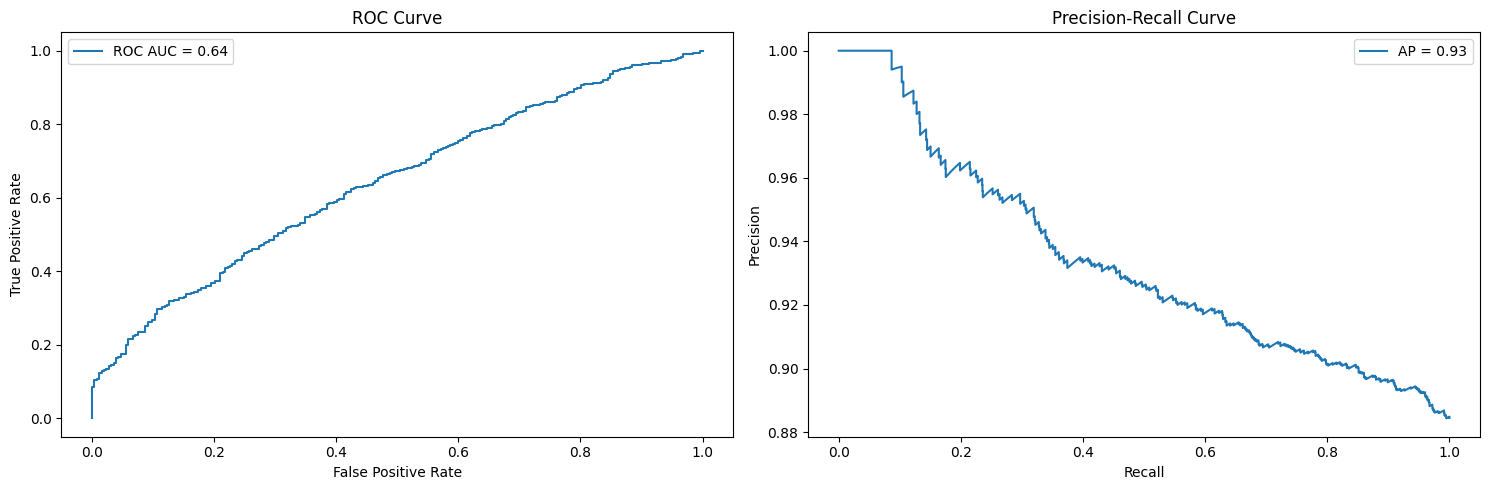


Training Student models...

Training Student Models...
Training RandomForest...
Training XGBoost...
Training DecisionTree...
Training Bagging...
Training AdaBoost...

Training Results:
          model  cv_f1_mean
0  RandomForest    0.983870
1       XGBoost    0.971792
2  DecisionTree    0.979184
3       Bagging    0.984356
4      AdaBoost    0.969459

Evaluating Student Models...


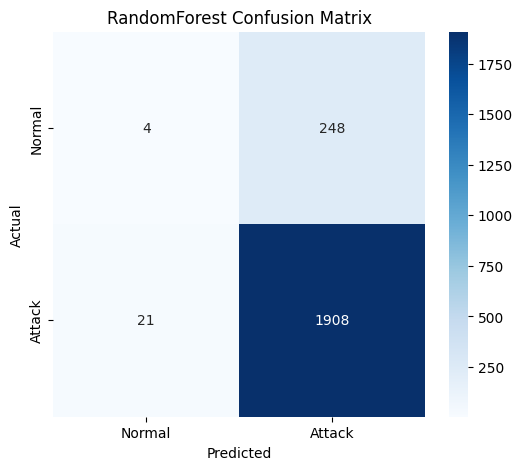

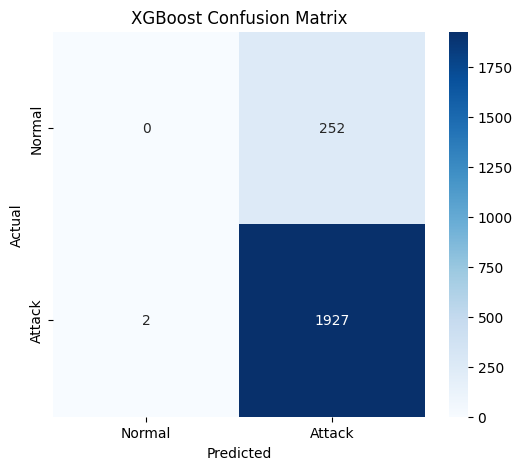

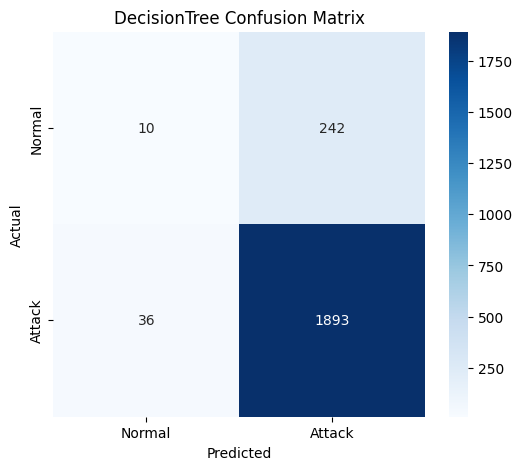

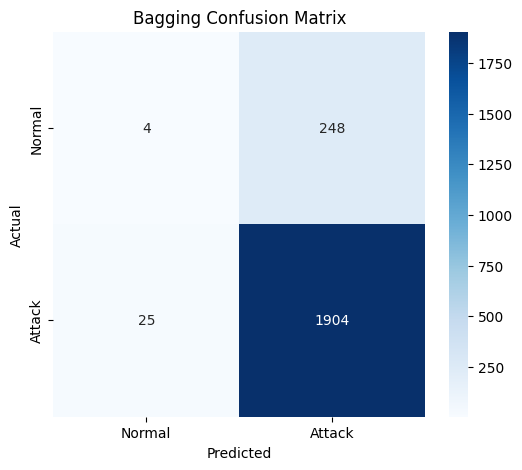

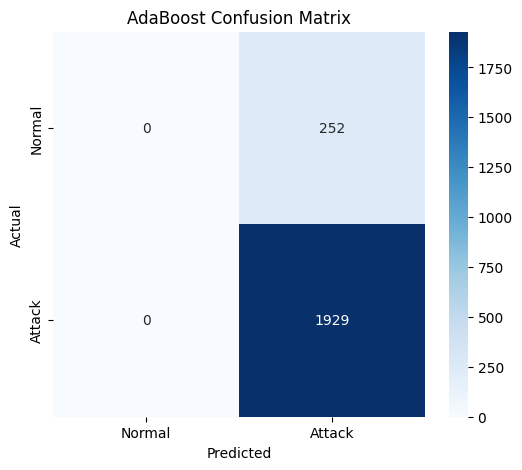


Evaluation Results:
  Student Model  Test Accuracy  F1-Score
0  RandomForest       0.876662  0.829552
1       XGBoost       0.883540  0.829770
2  DecisionTree       0.872536  0.831710
3       Bagging       0.874828  0.828580
4      AdaBoost       0.884457  0.830227

Best Student Model: Bagging
Teacher F1 Score: 0.830556202611671
Best Student F1 Score: 0.8295515954823195


In [ ]:
if __name__ == '__main__':

    weather_params = {
        'dataset': 'weather',
        'file_path': 'Train_Test_IoT_WeatherNormalAttackP.csv',
        'test_size': 0.20,
        'random_state': 42,
        'learning_rate': 0.001,
        'latent_dim': 16,
        'epochs': 100,
        'batch_size': 512,
        'patience': 15,
        'eval_size': 0.1,
        'student_cv_folds': 10,
        'student_model_params': {
            'XGBoost': {'max_depth': 5, 'learning_rate': 0.1},
            'RandomForest': {'n_estimators': 200}
        }
    }

    results = main(**weather_params)

    # Example of accessing results:
    print("\nBest Student Model:", results['student']['best_model']['name'])
    print("Teacher F1 Score:", results['teacher']['evaluation']['f1_score'])
    print("Best Student F1 Score:", results['student']['evaluation_results'].loc[0, 'F1-Score'])

Loading and preprocessing data...
Total records: 211043
Normal data: 50000
Attack data: 161043
Training data size: 7500, 15.000000000000002% normal data
Remaining data size: 203543, normal and attack data

Training Teacher model...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5857 - val_loss: 0.5399
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5020 - val_loss: 0.4919
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4420 - val_loss: 0.4412
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4018 - val_loss: 0.3872
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3506 - val_loss: 0.3389
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3001 - val_loss: 0.2950
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2536 - val_loss: 0.2565
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2100 - val_loss: 0.2315
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1923 - val_loss: 0.2115
E

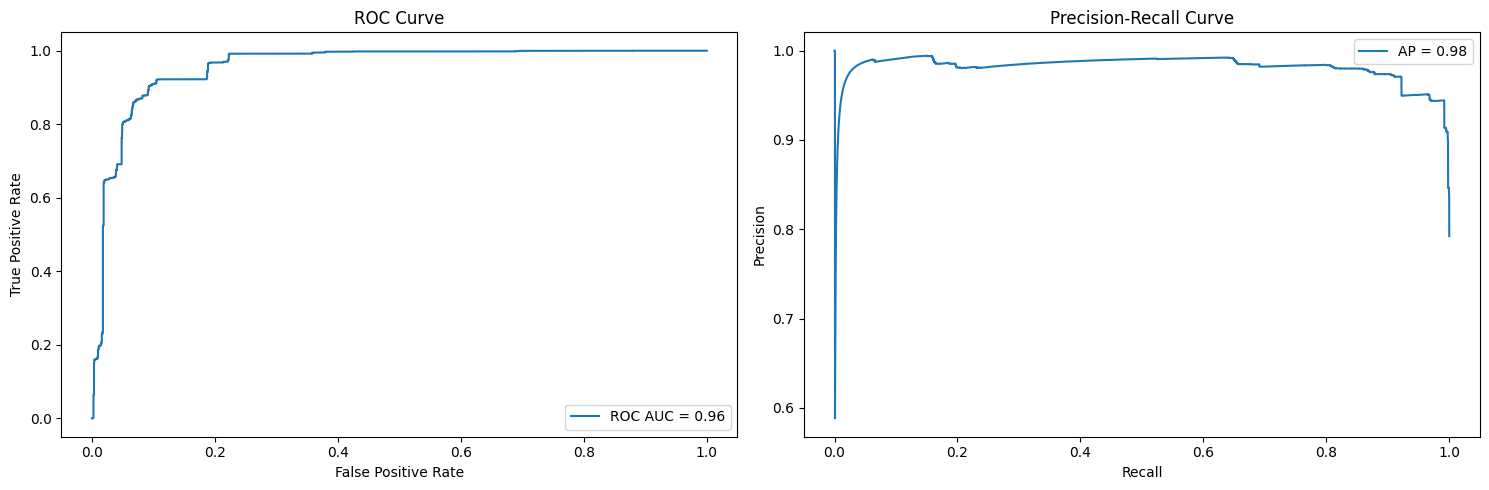


Training Student models...

Training Student Models...
Training RandomForest...
Training XGBoost...
Training DecisionTree...
Training Bagging...
Training AdaBoost...

Training Results:
          model  cv_f1_mean
0  RandomForest    0.999823
1       XGBoost    0.999672
2  DecisionTree    0.999720
3       Bagging    0.999734
4      AdaBoost    0.993678

Evaluating Student Models...


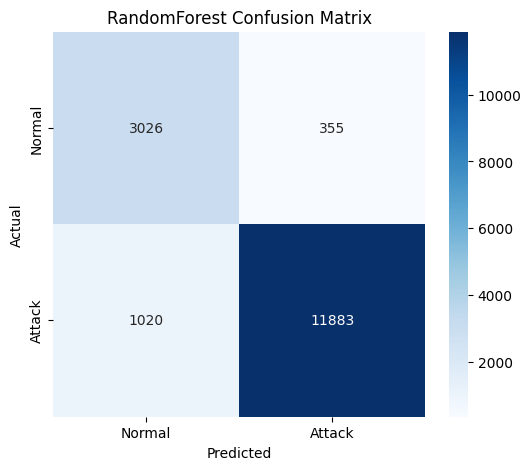

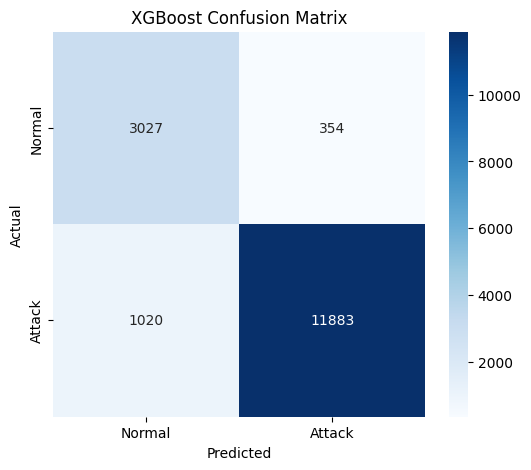

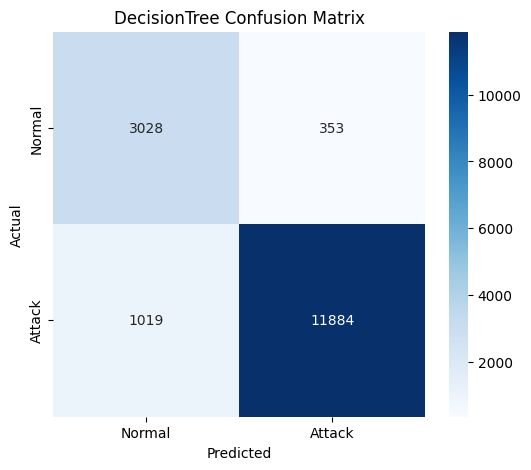

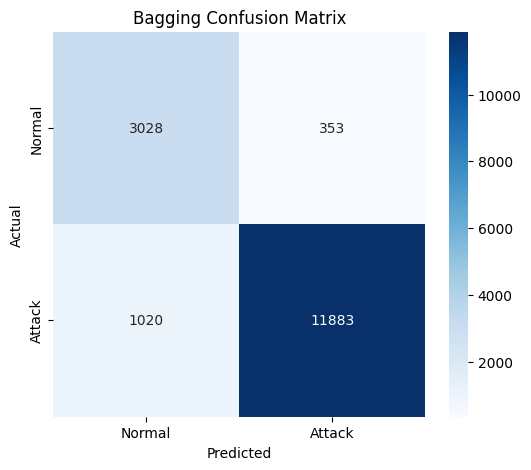

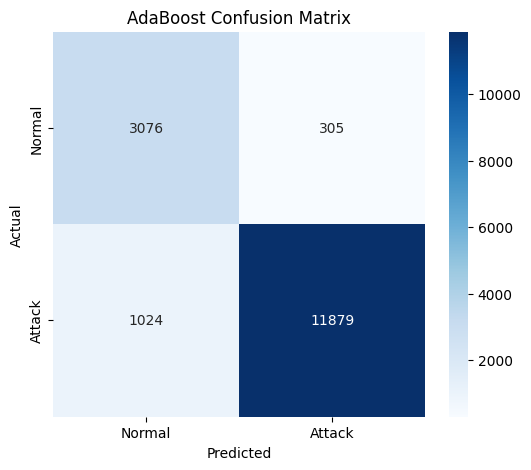


Evaluation Results:
  Student Model  Test Accuracy  F1-Score
0  RandomForest       0.915561  0.918225
1       XGBoost       0.915623  0.918288
2  DecisionTree       0.915746  0.918407
3       Bagging       0.915684  0.918351
4      AdaBoost       0.918386  0.921139

Best Student Model: RandomForest
Teacher F1 Score: 0.9180007385029719
Best Student F1 Score: 0.9182247946435537


In [8]:
if __name__ == '__main__':
    # Example usage with parameterized inputs
    network_params = {
        'dataset': 'network',
        'file_path': 'train_test_networkP.csv',
        'test_size': 0.85,
        'random_state': 42,
        'learning_rate': 0.001,
        'latent_dim': 32,
        'epochs': 100,
        'batch_size': 512,
        'patience': 5,
        'eval_size': 0.1,
        'student_cv_folds': 10,
        'student_model_params': {
            'XGBoost': {'max_depth': 5, 'learning_rate': 0.1},
            'RandomForest': {'n_estimators': 200}
        }
    }

    results = main(**network_params)

    # Example of accessing results:
    print("\nBest Student Model:", results['student']['best_model']['name'])
    print("Teacher F1 Score:", results['teacher']['evaluation']['f1_score'])
    print("Best Student F1 Score:", results['student']['evaluation_results'].loc[0, 'F1-Score'])